In [39]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import math

def psy_analytic(x, lamb = -1, case = 1):
    '''
        psy_analytic = np.exp(lamb*x)
    '''
    if case == 1:
        return tf.exp(lamb*x)
    elif case == 2:
        return tf.sin(x)
    elif case == 3:
        return -1 / (1 + x)

def f(x, psy, case = 1):
    if case == 1:
        '''
            d(psy)/dx = f(x, psy)
            y' = B(x) - A(x) * y
        '''
        def A(x, case = 1):
            if case == 1:
                return 1

        def B(x, case = 1):
            if case == 1:
                return 0

        return B(x) - A(x)*psy
    
    elif case == 2:
        '''
            Prothero Robinson
            y' 
        '''
        return -(psy - tf.sin(x)) + tf.cos(x)

    elif case == 3:
        return psy**2

def y(x, w, case = 1): 
    '''
        y(x) = bias + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + ... + wn*(x**n)
    '''
    if case == 1:
        bias = 1.
    elif case == 2:
        bias = 0.
    elif case == 3:
        bias = -1.

    y = bias
    w_v = w.variables[0]
    n = w_v.shape[0]
    for i in range(1, n+1):
        y += w_v[i-1]*x**i
    
    return y

def y_loss(x, w, case = 1):
    x = x.reshape(-1, 1)    # (x크기, 1)
    x = tf.constant(x, dtype = tf.float32)  # tensor 상수로 변형
    
    with tf.GradientTape() as tape:
        tape.watch(x)

        _y = y(x, w, case = case)
        d_y = tape.gradient(_y, x)
    
    _loss = d_y - f(x, _y, case)
    square_loss = tf.square(_loss)
    total_loss = tf.reduce_mean(square_loss)

    return total_loss

def y_EC_loss(x, w, NN, case = 1):
    x = x.reshape(-1, 1)    # (x크기, 1)
    x = tf.constant(x, dtype = tf.float32)  # tensor 상수로 변형

    with tf.GradientTape() as tape:
        tape.watch(x)

        y_EC = tf.add(y(x, w, case), NN(x)*x)
        d_y_EC = tape.gradient(y_EC, x)

    _loss = d_y_EC - f(x, y_EC, case)
    square_loss = tf.square(_loss)
    total_loss = tf.reduce_mean(square_loss)

    return total_loss

def PINN(x, NN, case = 1):
    x = x.reshape(-1, 1)
    x = tf.constant(x, dtype = tf.float32)
    x_0 = tf.zeros((1, 1))
    one = tf.ones((1, 1))

    with tf.GradientTape() as tape:
        tape.watch(x)

        PINN_NN = NN(x)
        d_PINN_NN = tape.gradient(PINN_NN, x)

    _loss = d_PINN_NN - f(x, PINN_NN, case)
    IC_loss = NN(x_0) - one
    square_loss = tf.square(_loss) + tf.square(IC_loss)
    total_loss = tf.reduce_mean(square_loss)

    return total_loss


def train(train_x, n, case):
    w = tf.Module()
    w.v = tf.Variable(tf.random.normal(shape=(n, ), dtype=tf.float32))

    NN = tf.keras.models.Sequential([
        tf.keras.layers.Input((1,)),
        tf.keras.layers.Dense(units = 32, activation = 'tanh'),
        tf.keras.layers.Dense(units = 64, activation = 'tanh'),
        tf.keras.layers.Dense(units = 64, activation = 'tanh'),
        tf.keras.layers.Dense(units = 32, activation = 'tanh'),
        tf.keras.layers.Dense(units = 1)
    ])

    learning_rate = 1e-3
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

    print('start y')
    for itr in range(3000):
        with tf.GradientTape() as tape:
            train_loss = y_loss(train_x, w, case)

            grad_w = tape.gradient(train_loss, w.trainable_variables)
            optimizer.apply_gradients(zip(grad_w, w.trainable_variables))

        if itr % 1000 == 0:
            print('iter : {}, loss : {}'.format(itr, train_loss.numpy()))

    print('start y + EC')
    for itr in range(3000):
        with tf.GradientTape() as tape:
            train_loss = y_EC_loss(train_x, w, NN, case)

            grad_NN = tape.gradient(train_loss, NN.trainable_variables)
            optimizer.apply_gradients(zip(grad_NN, NN.trainable_variables))

        if itr % 1000 == 0:
            print('iter : {}, loss : {}'.format(itr, train_loss.numpy()))
    
    return w, NN

def result_pred(train_x, case, w, NN):
    test_x = np.linspace(0, 1, 100).reshape(-1, 1)    # (x크기, 1)
    test_x = tf.constant(test_x, dtype = tf.float32)  # tensor 상수로 변형

    pred_y = y(test_x, w, case)
    NN_pred_y = tf.add(y(test_x, w, case), NN.predict(test_x)*test_x)

    test_x = np.linspace(0, 1, 100)
    train_y = psy_analytic(train_x, case = case)
    true_y = psy_analytic(test_x, case = case)

    return pred_y, NN_pred_y, train_y, true_y

def graph_show(train_x, train_y, true_y, pred_y, NN_pred_y):
    test_x = np.linspace(0, 1, 100).reshape(-1, 1)    # (x크기, 1)
    test_x = tf.constant(test_x, dtype = tf.float32)  # tensor 상수로 변형
    fig = plt.figure(figsize=(18,5))
    ax = fig.add_subplot(121)
    ax.plot(train_x, train_y, 'ob', label = 'Train')
    ax.plot(test_x, true_y, '-k', label = 'True')
    ax.plot(test_x, pred_y, '--r', label = 'Prediction')
    ax.plot(test_x, NN_pred_y, '--g', label = 'NN_Prediction')
    ax.tick_params(labelsize=10)
    ax.legend(fontsize=20)
    ax.grid()
    # Error
    ax2 = fig.add_subplot(122)
    plt.plot(test_x, tf.abs(np.array(pred_y).flatten() - true_y), '-r', label = 'Error')
    plt.plot(test_x, tf.abs(np.array(NN_pred_y).flatten() - true_y), '-g', label = 'NN_Error')
    ax2.tick_params(labelsize=10)
    ax2.legend(fontsize=20)
    ax2.grid()

def result_1(Epoch):
    '''
        result 1

        w 개수별
        polynomial Graph
        1. Exact
        2. 1st
        3. 2ed
        4. 3rd

        train_x = 0 ~ 1 사이 20개 균등 배열
        충분히 학습 될 때 까지, Epoch 10000
        Pn(x)로도 충분히 잘 근사 한다.
    '''
    w_1 = tf.Module()
    w_1.v = tf.Variable(tf.random.normal(shape=(1, ), dtype=tf.float32))

    w_2 = tf.Module()
    w_2.v = tf.Variable(tf.random.normal(shape=(2, ), dtype=tf.float32))

    w_3 = tf.Module()
    w_3.v = tf.Variable(tf.random.normal(shape=(3, ), dtype=tf.float32))


    learning_rate = 1e-3
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    train_x = np.array([i/20 for i in range(20)]).reshape((-1, 1))

    print('start y')
    for itr in range(Epoch):
        with tf.GradientTape() as tape:
            train_loss_1 = y_loss(train_x, w_1, 1)
            grad_w_1 = tape.gradient(train_loss_1, w_1.trainable_variables)
            optimizer.apply_gradients(zip(grad_w_1, w_1.trainable_variables))

        with tf.GradientTape() as tape:
            train_loss_2 = y_loss(train_x, w_2, 1)
            grad_w_2 = tape.gradient(train_loss_2, w_2.trainable_variables)
            optimizer.apply_gradients(zip(grad_w_2, w_2.trainable_variables))

        with tf.GradientTape() as tape:
            train_loss_3 = y_loss(train_x, w_3, 1)
            grad_w_3 = tape.gradient(train_loss_3, w_3.trainable_variables)
            optimizer.apply_gradients(zip(grad_w_3, w_3.trainable_variables))

        if itr % 1000 == 0:
            print('iter : {}, loss_1 : {}'.format(itr, train_loss_1.numpy()))
            print('iter : {}, loss_2 : {}'.format(itr, train_loss_2.numpy()))
            print('iter : {}, loss_3 : {}'.format(itr, train_loss_3.numpy()))

    # show_graph
    test_x = np.linspace(0, 1, 100)
    train_y = psy_analytic(train_x, lamb = -1, case = 1)
    true_y = psy_analytic(test_x, lamb = -1, case = 1)
    test_x = np.linspace(0, 1, 100).reshape(-1, 1)    # (x크기, 1)
    test_x = tf.constant(test_x, dtype = tf.float32)  # tensor 상수로 변형
    pred_y_1 = y(test_x, w_1, case = 1)
    pred_y_2 = y(test_x, w_2, case = 1)
    pred_y_3 = y(test_x, w_3, case = 1)

    fig = plt.figure(figsize=(18,5))
    ax = fig.add_subplot(121)

    ax.plot(train_x, train_y, 'ob', label = 'Train')
    ax.plot(test_x, true_y, '-k', label = 'Exact')
    ax.plot(test_x, pred_y_1, '--r', label = '1st')
    ax.plot(test_x, pred_y_2, '--b', label = '2ed')
    ax.plot(test_x, pred_y_3, '--g', label = '3rd')
    ax.set_xlabel('x', fontsize=15)
    ax.set_ylabel('y', fontsize=15)
    ax.set_title('y', fontsize=15)
    ax.tick_params(labelsize=10)
    ax.legend(fontsize=15)
    ax.grid()
    # Error
    ax2 = fig.add_subplot(122)
    ax2.plot(test_x, tf.abs(np.array(pred_y_1).flatten() - true_y), '-r', label = '1st Error')
    ax2.plot(test_x, tf.abs(np.array(pred_y_2).flatten() - true_y), '-b', label = '2ed Error')
    ax2.plot(test_x, tf.abs(np.array(pred_y_3).flatten() - true_y), '-g', label = '3rd Error')
    ax2.set_xlabel('x', fontsize=15)
    ax2.set_ylabel('Error', fontsize=15)
    ax2.set_title('Error', fontsize=15)
    ax2.tick_params(labelsize=10)
    ax2.legend( fontsize=15)
    ax2.grid()

def result_2(Epoch):
    '''
        result 2

        Error
        Poly + EC vs PINN

        setting
        train_x : 0 ~ 1 사이 20개 (균등 분배)
        layer 개수 : 4개
        weight : 32, 64, 64, 32
        optimizer function : tanh

        Poly weight 개수 : 3개
        Poly Epoch : 10,000

        Poly + EC, PINN Epoch : 1000, 10000
    '''
    w = tf.Module()
    w.v = tf.Variable(tf.random.normal(shape=(3, ), dtype=tf.float32))

    NN = tf.keras.models.Sequential([
        tf.keras.layers.Input((1,)),
        tf.keras.layers.Dense(units = 32, activation = 'tanh'),
        tf.keras.layers.Dense(units = 64, activation = 'tanh'),
        tf.keras.layers.Dense(units = 64, activation = 'tanh'),
        tf.keras.layers.Dense(units = 32, activation = 'tanh'),
        tf.keras.layers.Dense(units = 1)
    ])

    PINN_NN = tf.keras.models.Sequential([
        tf.keras.layers.Input((1,)),
        tf.keras.layers.Dense(units = 32, activation = 'tanh'),
        tf.keras.layers.Dense(units = 64, activation = 'tanh'),
        tf.keras.layers.Dense(units = 64, activation = 'tanh'),
        tf.keras.layers.Dense(units = 32, activation = 'tanh'),
        tf.keras.layers.Dense(units = 1)
    ])

    learning_rate = 1e-3
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    train_x = np.array([i/20 for i in range(20)]).reshape((-1, 1))

    print('start y')
    for itr in range(10000):
        with tf.GradientTape() as tape:
            train_loss = y_loss(train_x, w, case = 1)

            grad_w = tape.gradient(train_loss, w.trainable_variables)
            optimizer.apply_gradients(zip(grad_w, w.trainable_variables))

        if itr % 1000 == 0:
            print('iter : {}, y_loss : {}'.format(itr, train_loss.numpy()))

    print('start y + EC and PINN')
    for itr in range(Epoch):
        with tf.GradientTape() as tape:
            train_loss_NN = y_EC_loss(train_x, w, NN, case = 1)
            grad_NN = tape.gradient(train_loss_NN, NN.trainable_variables)
            optimizer.apply_gradients(zip(grad_NN, NN.trainable_variables))
        
        with tf.GradientTape() as tape:
            train_loss_PINN = PINN(train_x, PINN_NN, case = 1)
            grad_PINN_NN = tape.gradient(train_loss_PINN, PINN_NN.trainable_variables)
            optimizer.apply_gradients(zip(grad_PINN_NN, PINN_NN.trainable_variables))

        if itr % 1000 == 0:
            print('iter : {}, yEC_loss : {}'.format(itr, train_loss_NN.numpy()))
            print('iter : {}, PINN_loss : {}'.format(itr, train_loss_PINN.numpy()))

    # show_graph
    test_x = np.linspace(0, 1, 100)
    true_y = psy_analytic(test_x, lamb = -1, case = 1)
    test_x = np.linspace(0, 1, 100).reshape(-1, 1)    # (x크기, 1)
    test_x = tf.constant(test_x, dtype = tf.float32)  # tensor 상수로 변형
    NN_pred_y = tf.add(y(test_x, w, case = 1), NN.predict(test_x)*test_x)
    PINN_pred_y = PINN_NN.predict(test_x)

    fig = plt.figure(figsize=(18,5))

    # Error
    ax = fig.add_subplot(122)
    ax.plot(test_x, tf.abs(np.array(NN_pred_y).flatten() - true_y), '-r', label = 'y + EC')
    ax.plot(test_x, tf.abs(np.array(PINN_pred_y).flatten() - true_y), '-g', label = 'PINN')
    ax.set_xlabel('x', fontsize=15)
    ax.set_ylabel('Error', fontsize=15)
    ax.set_title('Error', fontsize=15)
    ax.tick_params(labelsize=10)
    ax.legend( fontsize=15)
    ax.grid()
    

result 1
---
w 개수별
polynomial Graph
1. Exact
2. 1st
3. 2ed
4. 3rd

train_x = 0 ~ 1 사이 20개 균등 배열

충분히 학습 될 때 까지, Epoch 10000

Pn(x)로도 충분히 잘 근사 한다.

start y
iter : 0, loss_1 : 1.7498676776885986
iter : 0, loss_2 : 6.411337375640869
iter : 0, loss_3 : 4.808595180511475
iter : 1000, loss_1 : 0.04485286399722099
iter : 1000, loss_2 : 0.12183225154876709
iter : 1000, loss_3 : 0.15671400725841522
iter : 2000, loss_1 : 0.03680190071463585
iter : 2000, loss_2 : 0.06632883846759796
iter : 2000, loss_3 : 0.047031790018081665
iter : 3000, loss_1 : 0.036801327019929886
iter : 3000, loss_2 : 0.03459334000945091
iter : 3000, loss_3 : 0.0184670127928257
iter : 4000, loss_1 : 0.036801327019929886
iter : 4000, loss_2 : 0.012113177217543125
iter : 4000, loss_3 : 0.014113853685557842
iter : 5000, loss_1 : 0.036801327019929886
iter : 5000, loss_2 : 0.0025202403776347637
iter : 5000, loss_3 : 0.01125961821526289
iter : 6000, loss_1 : 0.036801327019929886
iter : 6000, loss_2 : 0.0006686649285256863
iter : 6000, loss_3 : 0.007799044251441956
iter : 7000, loss_1 : 0.036801330745220184
iter : 7000, loss_2 : 0.0005656421417370439
iter : 7000, loss_3 : 0.00

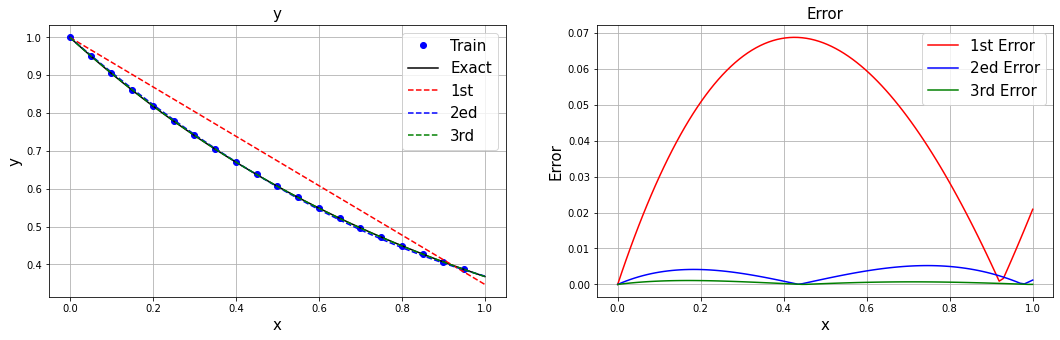

In [ ]:
result_1(10000)

result 2
---
Error Graph

Poly + EC vs PINN

setting
---
train_x : 0 ~ 1 사이 20개 (균등 분배)

layer 개수 : 4개

weight : 32, 64, 64, 32

optimizer function : tanh

Poly weight 개수 : 3개

Poly Epoch : 10,000

Poly + EC, PINN Epoch : 1000, 10000

start y
iter : 0, y_loss : 1.555135726928711
iter : 1000, y_loss : 0.23617756366729736
iter : 2000, y_loss : 0.037251390516757965
iter : 3000, y_loss : 0.015614059753715992
iter : 4000, y_loss : 0.010285449214279652
iter : 5000, y_loss : 0.005297453608363867
iter : 6000, y_loss : 0.001791823306120932
iter : 7000, y_loss : 0.00030649156542494893
iter : 8000, y_loss : 2.0019026123918593e-05
iter : 9000, y_loss : 3.986881438322598e-06
start y + EC and PINN
iter : 0, yEC_loss : 0.06892586499452591
iter : 0, PINN_loss : 1.000885248184204
4/4 [==============================] - 0s 977us/step


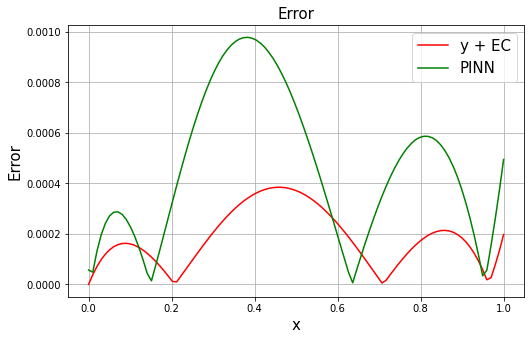

In [34]:
result_2(1000)

start y
iter : 0, y_loss : 0.2531868517398834
iter : 1000, y_loss : 0.029387274757027626
iter : 2000, y_loss : 0.007265648804605007
iter : 3000, y_loss : 0.0006782456766813993
iter : 4000, y_loss : 1.623510615900159e-05
iter : 5000, y_loss : 3.878044026350835e-06
iter : 6000, y_loss : 3.863423444272485e-06
iter : 7000, y_loss : 3.863413439830765e-06
iter : 8000, y_loss : 3.863425718009239e-06
iter : 9000, y_loss : 3.863414804072818e-06
start y + EC and PINN
iter : 0, yEC_loss : 0.050143562257289886
iter : 0, PINN_loss : 1.1803338527679443
iter : 1000, yEC_loss : 3.6749365790456068e-06
iter : 1000, PINN_loss : 3.92693436879199e-05
iter : 2000, yEC_loss : 3.641777539087343e-06
iter : 2000, PINN_loss : 2.0457580831134692e-05
iter : 3000, yEC_loss : 3.6106089282839093e-06
iter : 3000, PINN_loss : 5.82420261707739e-06
iter : 4000, yEC_loss : 3.5824027690978255e-06
iter : 4000, PINN_loss : 8.777977313911833e-07
iter : 5000, yEC_loss : 3.5475175081955967e-06
iter : 5000, PINN_loss : 6.2848152

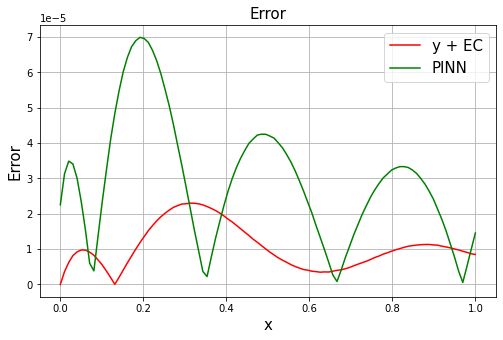

In [38]:
result_2(10000)